In [1]:
import os
import json
import math
import itertools
import operator

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import graph_tool
import graph_tool.draw
import graph_tool.centrality 

from bidict import bidict

In [2]:
data = pd.read_csv("actor_network.csv", header = 0, index_col = 0)
actors = pd.read_csv("~/Datasets/ucdp/actor/124918_1ucdp-actor-dataset-v2.2-2015csv.csv", header = 0, index_col = 0)

actor_indices = bidict()

def get_actor_index(actor):
    actor_index = actor_indices.get(actor, -1)
    if (actor_index < 0):
        actor_index = len(actor_indices)
        actor_indices[actor] = actor_index
    return(actor_index)

In [3]:
MIN_EDGE = 15

actor_indices.clear()
edge_list = [e for e in itertools.combinations(data.index.values, 2) if data[str(e[0])][e[1]] > MIN_EDGE]

edges = [(get_actor_index(e[0]), get_actor_index(e[1])) for e in edge_list]

In [4]:
g = graph_tool.Graph(directed=False)
g.add_edge_list(edges)

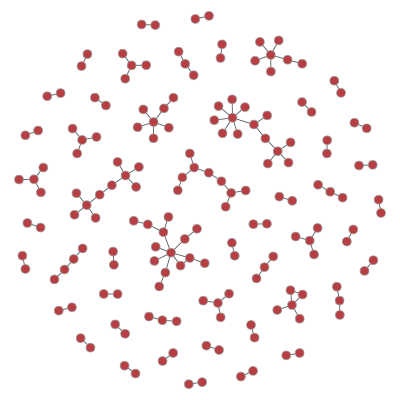

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x105b55f10, at 0x117e9ac90>

In [5]:
graph_size = 400
graph_tool.draw.graph_draw(g, output_size=(graph_size, graph_size))

In [6]:
g.vertex_properties['label'] = g.new_vertex_property('string')
for v in g.vertices():
    g.vertex_properties['label'][v] = actors.loc[actor_indices.inv[g.vertex_index[v]]]["name data"]
print('g vert/edges: ',g.num_vertices(), g.num_edges())

#add edge weight property
g.edge_properties['weight'] = g.new_edge_property('double')
g.edge_properties['color'] = g.new_edge_property('vector<double>')
for e in g.edges():
    w = data[str(actor_indices.inv[e.source()])][actor_indices.inv[e.target()]]
    g.edge_properties['weight'][e] = w
    alpha = (float(w)/data.values.max()) + .025
    g.edge_properties['color'][e] = [103/255.0,134/255.0,239/255.0,alpha]      

('g vert/edges: ', 169, 121)


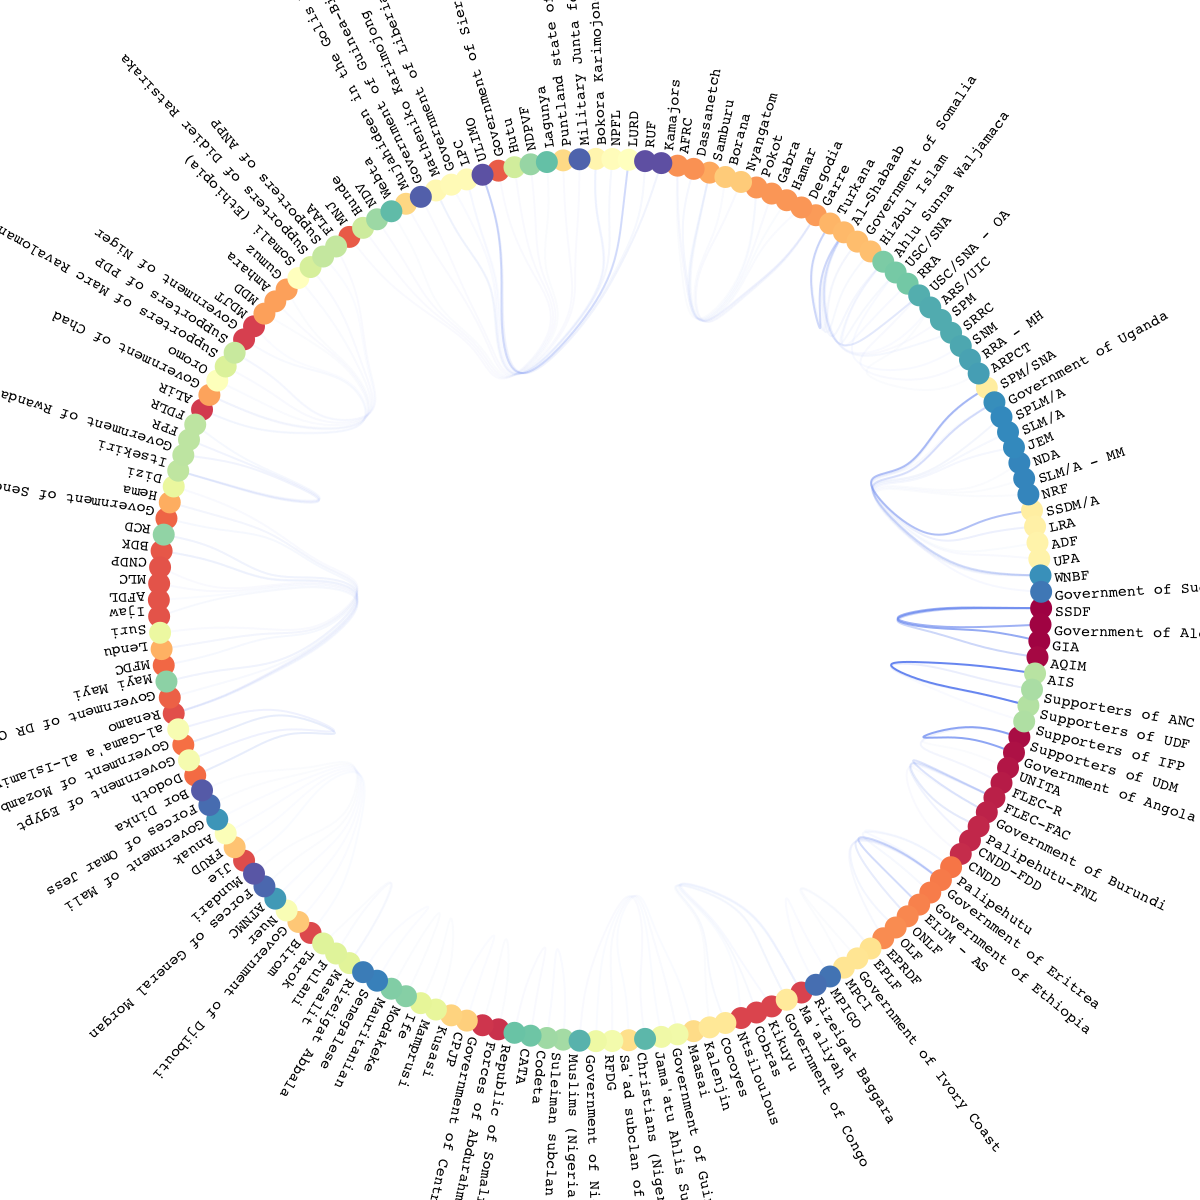

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x105b55f10, at 0x11af2a550>

In [11]:
graph_size = 600

state = graph_tool.community.minimize_nested_blockmodel_dl(g,deg_corr=False, eweight=g.ep['weight'])
bstack = state.get_bstack()
t = graph_tool.community.get_hierarchy_tree(state)[0]
tpos = pos = graph_tool.draw.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = graph_tool.draw.get_hierarchy_control_points(g, t, tpos, beta = .85)
pos = g.own_property(tpos)
b = bstack[0].vp["b"]

#text rotation
text_rot = g.new_vertex_property('double')
g.vertex_properties['text_rot'] = text_rot
for v in g.vertices():
    if pos[v][0] >0:
        text_rot[v] = math.atan(pos[v][1]/pos[v][0])
    else:
        text_rot[v] = math.pi + math.atan(pos[v][1]/pos[v][0])

graph_tool.draw.graph_draw(g, pos=pos, vertex_fill_color=b,
            edge_control_points=cts,
            vertex_size=20,
            vertex_text=g.vertex_properties['label'],
            vertex_text_rotation=g.vertex_properties['text_rot'],
            vertex_text_position=1,
            vertex_font_size=15,
            vertex_font_family='mono',
            vertex_anchor=0,
            vertex_color=b,
            vcmap=matplotlib.cm.Spectral,
            ecmap=matplotlib.cm.Spectral,
            edge_color=g.edge_properties['color'],
            #bg_color=[0,0,0,1],
            output_size=[graph_size*2,graph_size*2]
            #, output='ged_actors_%d.png' % MIN_EDGE)
            )